In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')
df_predict = pd.read_csv('test.csv')

In [2]:
print(df_train.isnull().sum())
df_train.head(3)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [10]:
def process_raw_df(df):
    df_data = df.drop(['PassengerId', 'Age', 'Cabin', 'Ticket', 'Name'], axis=1)    
    df_data = df_data.loc[df_data['Embarked'].notnull()]
    df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
    
    try:
        se_Y = df_data['Survived']
        df_X = df_data.drop(['Survived'], axis=1)
    except KeyError:
        se_Y = None
        df_X = df_data    
    
    return df_X, se_Y

In [11]:
df_Xtrain, se_Ytrain = process_raw_df(df_train)
df_Xpredict, _ = process_raw_df(df_predict)

df_Xtrain = pd.get_dummies(df_Xtrain)
df_Xpredict = pd.get_dummies(df_Xpredict)

In [5]:
from sklearn.model_selection import train_test_split
df_X_train, df_X_test, se_y_train, se_y_test = train_test_split(df_Xtrain, 
                                                                se_Ytrain, 
                                                                test_size=0.2)

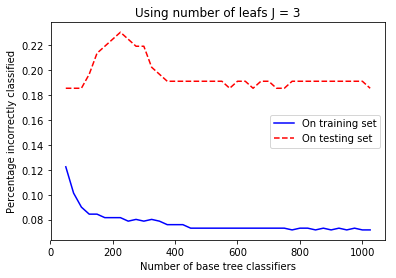

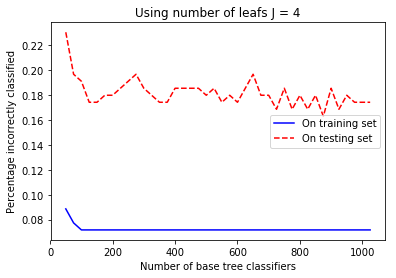

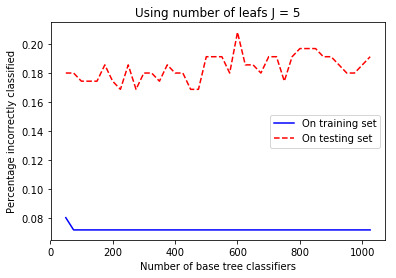

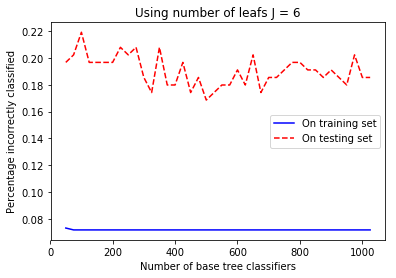

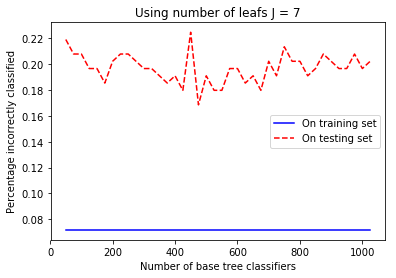

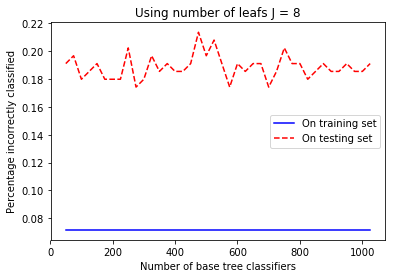

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

for num_leaf in range(3,9):
    train_errors, test_errors = [], []
    dtc = DecisionTreeClassifier(max_leaf_nodes=num_leaf)
    num_est_range = list(range(50,1050,25))
    
    for num_est in num_est_range:
        adb_clf = AdaBoostClassifier(base_estimator=dtc, n_estimators=num_est)
        adb_clf.fit(df_X_train, se_y_train)
        train_errors.append(1 - adb_clf.score(df_X_train, se_y_train))
        test_errors.append(1 - adb_clf.score(df_X_test, se_y_test))
    
    # plot figure
    plt.figure()
    plt.plot(num_est_range, train_errors, 'b', label='On training set')
    plt.plot(num_est_range, test_errors, 'r--', label='On testing set')
    plt.legend(loc='right')
    plt.title('Using number of leafs J = %d' % num_leaf)
    plt.xlabel('Number of base tree classifiers')
    plt.ylabel('Percentage incorrectly classified')

In [13]:
# Producing the Submission
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=6), n_estimators=500)
clf.fit(df_X_train, se_y_train)
predictions = clf.predict(df_Xpredict)
df_submission = pd.DataFrame({'PassengerId': df_predict['PassengerId'],
                              'Survived': predictions})
df_submission.to_csv('submission.csv', index=False)